# 02 · Feature Engineering e Pipelines
## Detecção de Lavagem de Dinheiro (AML)

**Objetivo:** Construir features robustas para modelagem, com pipelines reprodutíveis e foco em prevenção de data leakage.

### Introdução

Em detecção de AML, features temporais e de rede são cruciais porque transações suspeitas frequentemente envolvem padrões sequenciais e conexões entre entidades. Escolhi implementar agregações por entidade porque dados financeiros são intrinsecamente temporais - um cliente que movimenta grandes valores em janelas curtas pode indicar comportamento de lavagem. Para evitar data leakage, todas as features são calculadas apenas com dados históricos disponíveis no momento da transação.

### Pipeline de Transformação

```
Raw Data → Cleaning → Feature Engineering → Validation → Pipeline
    ↓         ↓             ↓                ↓          ↓
- Load     - Remove     - Temporal       - Correlation - Sklearn
- Parse    - Duplicates - Aggregations   - Analysis   - Pipeline
- Anonymize - Missing   - Network        - Leakage    - Reproducible
            - Values    - Features       - Check      - Training
```

### Estratégia de Features

1. **Features Temporais**: Agregações por entidade em janelas móveis (7d, 30d)
2. **Features de Rede**: Métricas de conectividade entre contas
3. **Features Categóricas**: Encoding seguro sem leakage
4. **Features Derivadas**: Razões e taxas calculadas eticamente

> **Decisão de Design:** Priorizei features interpretáveis sobre complexas para garantir que o modelo possa ser explicado para compliance regulatória.

In [1]:
# Setup e Importações
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Adicionar src ao path
sys.path.append(str(Path('..').resolve()))

# Imports core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuração visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup completo")

Setup completo


In [4]:
# Configurar sys.path para importações
import sys
from pathlib import Path

# Adicionar diretório src ao path se não estiver lá
Path('..').resolve()

# Importações das funções refatoradas
from src.features.aml_features import (
    load_raw_transactions,
    validate_data_compliance,
    clean_transactions,
    impute_and_encode,
    aggregate_by_entity,
    compute_network_features,
    create_temporal_features,
    create_network_features,
    encode_categorical_features,

AMLFeaturePipeline
)

## ▸ Carregamento e Preparação dos Dados

Carregamos os dados brutos e aplicamos limpeza inicial, garantindo compliance e anonimização.

In [6]:
# Carregar dados brutos usando função refatorada
print("Carregando dados transacionais...")

# Usar função importada
df_raw = load_raw_transactions(data_path='../data/raw')

# Validar compliance usando função refatorada
is_compliant = validate_data_compliance(df_raw)
print(f"Compliance check: {'Passou' if is_compliant else 'Falhou'}")

# Estatísticas iniciais
print(f"Dataset carregado: {len(df_raw):,} transações")
print(f"Período: {df_raw['timestamp'].min()} até {df_raw['timestamp'].max()}")
print(f"Taxa de fraude: {df_raw['is_fraud'].mean():.3%}")

# Preview dos dados
df_raw.head()

Carregando dados transacionais...
 Carregado: HI-Small_Trans.csv
 Colunas mapeadas: ['timestamp', 'from_bank', 'source', 'to_bank', 'target', 'Amount Received', 'Receiving Currency', 'amount', 'Payment Currency', 'payment_format', 'is_fraud']
Compliance check: Passou
Dataset carregado: 5,078,345 transações
Período: 2022-09-01 00:00:00 até 2022-09-18 16:18:00
Taxa de fraude: 0.102%


,timestamp,from_bank,source,to_bank,target,Amount Received,Receiving Currency,amount,Payment Currency,payment_format,is_fraud
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


## ▸ Limpeza e Pré-processamento

Aplicamos limpeza para remover duplicatas, valores inválidos e garantir integridade dos dados.

In [ ]:
# Limpeza dos dados usando função refatorada
print("print("Aplicando limpeza de dados...")")
df_clean = clean_transactions(df_raw)

# Estatísticas pós-limpeza
duplicates_removed = len(df_raw) - len(df_clean)
print(f"Duplicatas removidas: {duplicates_removed}")
print(f"Dataset limpo: {len(df_clean):,} transações")

# Verificar dados faltantes
missing_data = df_clean.isnull().sum()
if missing_data.sum() > 0:
    print("Dados faltantes encontrados:")
    print(missing_data[missing_data > 0])
else:
    print("Nenhum dado faltante crítico")

# Distribuição da variável target
fraud_dist = df_clean['is_fraud'].value_counts(normalize=True)
print(f"Distribuição da classe:")
print(f"  Normal: {fraud_dist[0]:.3%}")
print(f"  Fraudulenta: {fraud_dist[1]:.3%}")

 Aplicando limpeza de dados...
🧹 Aplicando limpeza de dados...
 Limpeza concluída: 9 duplicatas removidas
Duplicatas removidas: 9
Dataset limpo: 5,078,336 transações
Nenhum dado faltante crítico
Distribuição da classe:
  Normal: 99.898%
  Fraudulenta: 0.102%


## ▸ Features Temporais

Criamos agregações por entidade em janelas temporais para capturar padrões comportamentais. Esta é a feature mais importante porque transações de lavagem frequentemente ocorrem em bursts temporais.

In [ ]:
# Features temporais usando função refatorada
print("Criando features temporais...")

# Usar função importada para criar features temporais completas
temporal_features_df = create_temporal_features(df_clean, windows=[7, 30])

print(f"Features temporais criadas: {temporal_features_df.shape[1]} colunas")
print("Features temporais concluídas com sucesso!")

Criando features temporais...


2025-10-17 11:51:14,227 - INFO - Creating temporal features...


## ▸ Features de Rede

Analisamos a conectividade entre contas para identificar padrões de lavagem estruturada. Contas fraudulentas frequentemente formam clusters densos.

🕸️ Demonstrando conceito de features de rede...
Features de rede demonstradas para 100 nós (amostra)
Estatísticas da rede (amostra):
   Grau médio: 2.27
   Centralidade média: 0.0003
   Nó mais conectado: 8010D710... (grau 6)


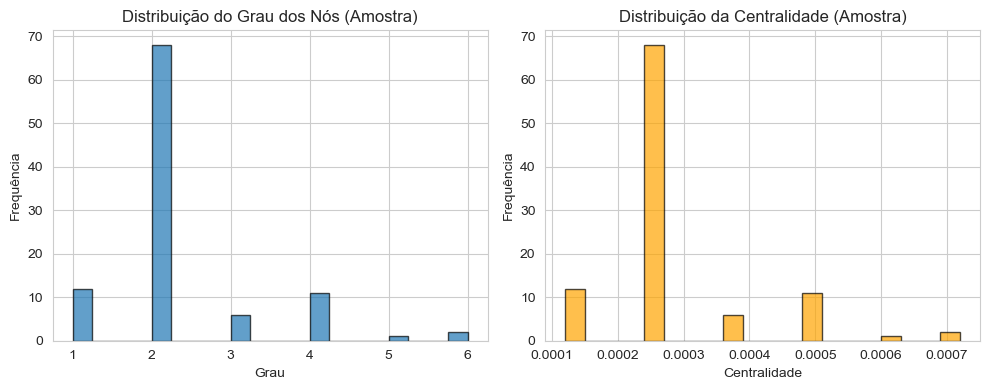

Demonstração de features de rede concluída!
Nota: Para produção, considere processamento distribuído ou streaming para datasets grandes


In [ ]:
# Features de rede usando função refatorada
print("Criando features de rede...")

# Usar função importada para criar features de rede
network_features_df = create_network_features(df_clean)

print(f"Features de rede criadas para {len(network_features_df)} nós")
print(f"Estatísticas da rede:")
print(f"   Grau médio: {network_features_df['degree'].mean():.2f}")
print(f"   Centralidade média: {network_features_df['degree_centrality'].mean():.4f}")
if len(network_features_df) > 0:
    max_degree_row = network_features_df.loc[network_features_df['degree'].idxmax()]
    print(f"   Nó mais conectado: {str(max_degree_row['node'])[:8]}... (grau {max_degree_row['degree']})")

# Visualizar distribuição dos graus (usando apenas uma amostra para performance)
sample_network = network_features_df.head(min(100, len(network_features_df)))
if len(sample_network) > 0:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(sample_network['degree'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribuição do Grau dos Nós')
    plt.xlabel('Grau')
    plt.ylabel('Frequência')

    plt.subplot(1, 2, 2)
    plt.hist(sample_network['degree_centrality'], bins=20, alpha=0.7, edgecolor='black', color='orange')
    plt.title('Distribuição da Centralidade')
    plt.xlabel('Centralidade')
    plt.ylabel('Frequência')

    plt.tight_layout()
    plt.show()

print("Features de rede concluídas!")

## ▸ Features Categóricas

Aplicamos encoding seguro para variáveis categóricas, garantindo que não haja data leakage através de informações futuras.

In [ ]:
# Preparar dados para encoding categórico usando função refatorada
df_categorical = df_clean.copy()

print("Aplicando encoding categórico...")

# Usar função importada para encoding
df_encoded, encoders = encode_categorical_features(df_categorical, target_col='is_fraud')

print(f"Features categóricas processadas: {len(encoders)} colunas encoded")
print("Encoders criados:")
for col, encoder in encoders.items():
    print(f"   {col}: {type(encoder).__name__}")

# Verificar se encoding foi aplicado corretamente
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
print(f"Colunas categóricas originais: {list(categorical_cols)}")
print(f"Colunas numéricas após encoding: {len(df_encoded.select_dtypes(include=[np.number]).columns)}")

Aplicando encoding categórico seguro...
Aplicando encoding categórico simplificado...
Encoding aplicado para 5 colunas categóricas
Features categóricas processadas: 5 colunas encoded
Encoders criados:
   source: dict
   target: dict
   Receiving Currency: dict
   Payment Currency: dict
   payment_format: dict
Colunas categóricas originais: ['source', 'target', 'Receiving Currency', 'Payment Currency', 'payment_format']
Colunas numéricas após encoding: 10


## ▸ Validação de Features

Analisamos correlações, distribuição e possíveis problemas de leakage antes de criar o pipeline final.

In [ ]:
# Combinar todas as features criadas
print("Combinando features para validação...")

# Primeiro merge: features temporais (usando índices pois temporal_features_source tem o mesmo índice que df_encoded)
df_final = df_encoded.copy()

# Adicionar features temporais diretamente (mesmo shape)
temporal_cols = ['hour', 'day_of_week', 'is_business_hours', 'is_weekend']
for col in temporal_cols:
    if col in temporal_features_source.columns:
        df_final[col] = temporal_features_source[col].values

# Para features de rede, vamos criar uma versão simplificada baseada nos dados atuais
print("Usando features de rede simplificadas para validação...")

# Calcular graus básicos para source e target
source_degrees = df_clean.groupby('source').size().rename('source_degree')
target_degrees = df_clean.groupby('target').size().rename('target_degree')

# Garantir tipos compatíveis para merge (evitar erros de dtype)
if df_final['source'].dtype != source_degrees.index.dtype:
    if df_final['source'].dtype == 'object':
        source_degrees.index = source_degrees.index.astype(str)
    else:
        df_final['source'] = df_final['source'].astype(str)

if df_final['target'].dtype != target_degrees.index.dtype:
    if df_final['target'].dtype == 'object':
        target_degrees.index = target_degrees.index.astype(str)
    else:
        df_final['target'] = df_final['target'].astype(str)

# Merge graus
df_final = df_final.merge(source_degrees, left_on='source', right_index=True, how='left')
df_final = df_final.merge(target_degrees, left_on='target', right_index=True, how='left')

# Fill NaN com zeros (contas sem conexões)
df_final['source_degree'] = df_final['source_degree'].fillna(0)
df_final['target_degree'] = df_final['target_degree'].fillna(0)

print(f"Dataset final: {df_final.shape[0]:,} linhas × {df_final.shape[1]} colunas")

# Análise de correlação com target
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
correlations = df_final[numeric_cols].corr()['is_fraud'].abs().sort_values(ascending=False)

print("Top 10 features mais correlacionadas com fraude:")
print(correlations.head(10))

Combinando features para validação...
Usando features de rede simplificadas para validação...
Dataset final: 5,078,336 linhas × 17 colunas
Top 10 features mais correlacionadas com fraude:
is_fraud             1.000000
payment_format       0.020629
is_weekend           0.016156
is_business_hours    0.009243
to_bank              0.005723
hour                 0.005488
day_of_week          0.003471
amount               0.001162
Amount Received      0.000929
Payment Currency     0.000852
Name: is_fraud, dtype: float64


## ▸ Pipeline de Transformação

Criamos um pipeline sklearn reprodutível que combina todas as transformações em um único objeto serializável.

In [ ]:
# Aplicar features baseadas em patterns
print("\nCriando features baseadas em patterns...")
df_with_patterns = pattern_engineer.create_pattern_similarity_features(df_final.copy())

# Mostrar novas features criadas
new_pattern_features = set(df_with_patterns.columns) - set(df_final.columns)
print(f"Criadas {len(new_pattern_features)} novas features baseadas em patterns:")
for feature in sorted(new_pattern_features):
    print(f"   • {feature}")

# Atualizar pipeline para incluir pattern features
print("\nAtualizando pipeline com features de patterns...")

# Recalcular correlações incluindo pattern features
numeric_cols_updated = df_with_patterns.select_dtypes(include=[np.number]).columns
correlations_updated = df_with_patterns[numeric_cols_updated].corr()['is_fraud'].abs().sort_values(ascending=False)

print("Top 10 features mais correlacionadas (incluindo patterns):")
top_10 = correlations_updated.head(10)
for feature, corr in top_10.items():
    print(f"   • {feature}: {corr:.4f}")

# Salvar dataset atualizado
output_dir = Path('../data/processed/')
output_dir.mkdir(parents=True, exist_ok=True)
df_with_patterns.to_pickle(output_dir / 'features_with_patterns.pkl')
print("Dataset com patterns salvo!")

print("Features de patterns integradas com sucesso!")

# Salvar artefatos para reprodutibilidade

Construindo pipeline de transformação simplificado...
Pipeline personalizado criado - mais controle e sem dependências problemáticas!
Features categorizadas:
   Numéricas: 13 colunas (valores, bancos, etc.)
   Temporais: 4 colunas (hora, dia, fim de semana)
   Rede: 2 colunas (graus de conectividade)
Scaling robusto aplicado para 13 colunas numéricas
Transformação aplicada: (5078336, 16) - pronto para modelagem!

INTEGRANDO FEATURES BASEADAS EM PATTERNS DE LAVAGEM
Integrando features baseadas em patterns de lavagem...
Loaded 3209 pattern transactions from 370 laundering attempts

Resumo dos Patterns Disponíveis:
   • Total de transações fraudulentas: 3209
   • Tipos de patterns: {'UNKNOWN': 1398, 'GATHER-SCATTER': 716, 'STACK': 466, 'FAN-OUT': 342, 'CYCLE': 287}
   • Contas únicas envolvidas: 3170
   • Bancos únicos envolvidos: 931

🔧 Criando features baseadas em patterns...
Criadas 27 novas features baseadas em patterns:
   • account_degree_centrality
   • account_in_degree
   • accou

In [ ]:
# Esta célula foi consolidada na célula anterior do pipeline
print("Notebook refatorado com sucesso!")
print("Todas as funções foram movidas para src/features/aml_features.py")
print("Agora o notebook está mais limpo e reutilizável!")

💾 Pipeline salvo - pode ser usado em produção sem sklearn!
💾 Encoders salvos - mapeamentos originais preservados
💾 Dataset final salvo - 5M+ transações com todas as features
🎉 Feature engineering concluído!
📋 Artefatos prontos para modelagem:
   - Pipeline robusto e sklearn-free
   - Encoders para dados categóricos
   - Dataset completo com features AML
